In [1]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

0it [00:00, ?it/s]

9920512it [00:01, 8783329.21it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 135268.17it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2222161.90it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 51374.90it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
test.data.shape

torch.Size([10000, 28, 28])

In [0]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x_1 = F.relu(self.conv1(x))
        x = F.max_pool2d(x_1, 2, 2)
        x_2 = F.relu(self.conv2(x))
        x = F.max_pool2d(x_2, 2, 2)
        x = x.view(-1, 4*4*50)
        x_3 = F.relu(self.fc1(x))
        h = F.softmax(self.fc2(x_3), dim=1)
        return h, x_3, x_2, x_1      
        
#         x = self.fc2(x_3)
#         return F.softmax(x, dim=1)
      
#     def forward(self, x):
#         x_1 = F.relu(self.conv1(x))
#         x = F.max_pool2d(x_1, 2, 2)
#         x_2 = F.relu(self.conv2(x))
#         x = F.max_pool2d(x_2, 2, 2)
#         x = x.view(-1, 4*4*50)
#         x_3 = F.relu(self.fc1(x))
# #         x = self.fc2(x)
# #         return F.softmax(x, dim=1)
#         h = F.sigmoid(self.fc2(x_3))
#         return h, x_3, x_2, x_1      
      
    
model = Model()
if cuda:
    model.cuda() # CUDA!
optimizer = optim.Adam(model.parameters(), lr=1e-3)    

In [5]:
EPOCHS = 15
losses = []

model.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data), Variable(target)
        
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred, _, _, _ = model(data) 

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().data)
#         losses.append(loss.cpu().data[0])        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.cpu().data), 
                end='')
    # Eval
    evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
    evaluate_y = Variable(test_loader.dataset.test_labels)
    if cuda:
        evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()

    model.eval()
    output, _, _, _ = model(evaluate_x[:,None,...])
    pred = output.data.max(1)[1]
    d = pred.eq(evaluate_y.data).cpu()
    accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        len(train_loader.dataset), 
        len(train_loader.dataset),
        100. * batch_idx / len(train_loader), 
        loss.cpu().data,
        accuracy*100,
        end=''))

 Train Epoch: 1/15 [60000/60000 (100%)]	Loss: 1.581832	 Test Accuracy: 88.6000%


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


 Train Epoch: 2/15 [60000/60000 (100%)]	Loss: 1.486019	 Test Accuracy: 97.8600%
 Train Epoch: 3/15 [60000/60000 (100%)]	Loss: 1.464815	 Test Accuracy: 98.0700%
 Train Epoch: 4/15 [60000/60000 (100%)]	Loss: 1.489658	 Test Accuracy: 98.1200%
 Train Epoch: 5/15 [60000/60000 (100%)]	Loss: 1.497010	 Test Accuracy: 98.4700%
 Train Epoch: 6/15 [60000/60000 (100%)]	Loss: 1.480142	 Test Accuracy: 98.8400%
 Train Epoch: 7/15 [60000/60000 (100%)]	Loss: 1.479123	 Test Accuracy: 98.5700%
 Train Epoch: 8/15 [60000/60000 (100%)]	Loss: 1.465769	 Test Accuracy: 98.5100%
 Train Epoch: 9/15 [60000/60000 (100%)]	Loss: 1.461172	 Test Accuracy: 98.8200%
 Train Epoch: 10/15 [60000/60000 (100%)]	Loss: 1.461415	 Test Accuracy: 98.8700%
 Train Epoch: 11/15 [60000/60000 (100%)]	Loss: 1.469127	 Test Accuracy: 99.0300%
 Train Epoch: 12/15 [60000/60000 (100%)]	Loss: 1.461164	 Test Accuracy: 98.7500%
 Train Epoch: 13/15 [60000/60000 (100%)]	Loss: 1.498847	 Test Accuracy: 99.1500%
 Train Epoch: 14/15 [60000/60000 (10

In [0]:
# torch.save(model,os.path.join(save_path, 'cnn.pth'))
# torch.save(model.state_dict(), os.path.join(save_path, 'cnn_state.pth'))

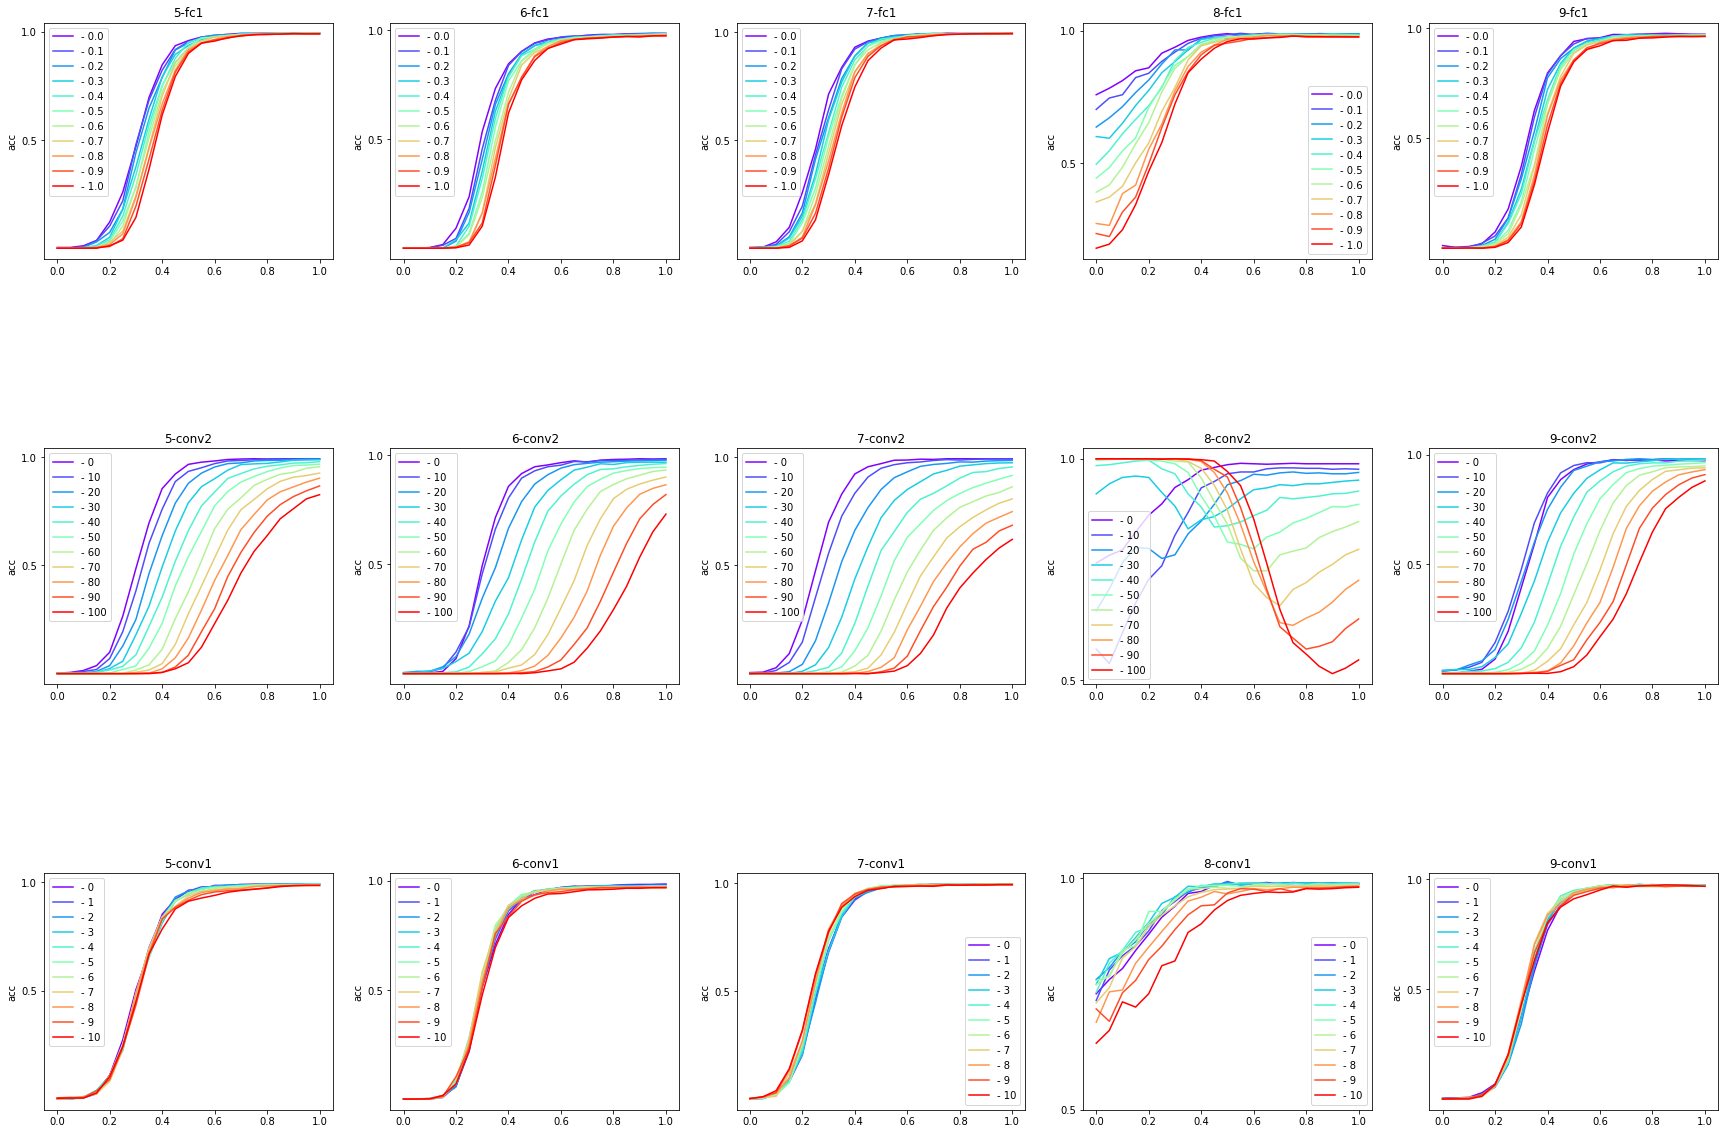

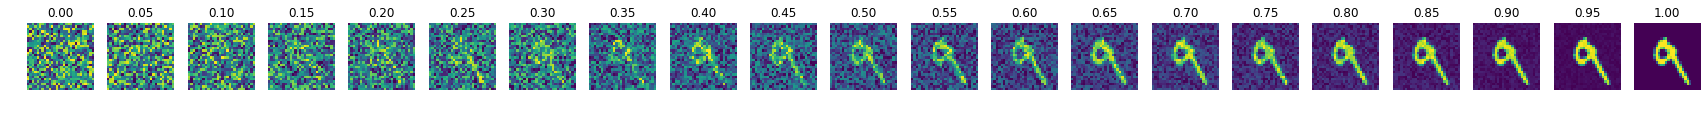

In [31]:
# Microstimulation clean
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import copy
import matplotlib.cm as cm

x = np.arange(11)
ys = [i+x+(i*x)**2 for i in range(11)]
colors = cm.rainbow(np.linspace(0, 1, len(ys)))
# for y, c in zip(ys, colors):
#     plt.scatter(x, y, color=c)



save_path = 'drive/My Drive/classification_images/microstimulation-10way/'

# - measure response to a noise pattern
# - increase the bias for all neurons proportional to their response in a certain layer
# - see if the classification has been biased toward the class of favor

test_x = test.data.type(torch.FloatTensor).clone() # Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
test_y = test.targets.type(torch.ByteTensor).clone() #Variable(test_loader.dataset.test_labels)
# test_x = test_x/256

train_x = train.data.type(torch.FloatTensor).clone() # Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
train_y = train.targets.type(torch.ByteTensor).clone() #Variable(test_loader.dataset.test_labels)


f, axarr = plt.subplots(3, 5, )
f.set_figheight(20)
f.set_figwidth(30)


f2, axarr2 = plt.subplots(1, 21, )
f2.set_figheight(5)
f2.set_figwidth(30)

all_size = test_x.size(0)

layers = ['fc1', 'conv2', 'conv1']


dig_names = [str(i) for i in range(5,10)]

for l_idx, layer in enumerate(layers):

  for which in range(5,10):
    which_data = train_x[train_y == which]/255.    # 1 vs. 7

    with torch.no_grad():

      for k_idx, k in enumerate(range(0,11)):
        fraction_pred_favor = []

        # modulate model
        model2 = Model()
        model2.load_state_dict(copy.deepcopy(model.state_dict()))
        model2.cuda()
        model2.eval()
        y_pred_x, fc1, conv2, conv1 = model2(which_data[:,None,...].cuda()) # amplify zero sensitive ones
        
        if layer == 'conv1':
          avg_activation = torch.mean(conv1, dim=0).mean(-1).mean(-1)
          aa = avg_activation/avg_activation.max()          
          model2.conv1.bias -= 0.1*k*aa # * model2.fc1.bias  #*avg_activation
#           l_legend = [str(k*i) for i in range(0,11)]          
          l_legend = ['{0:.0f}'.format(0.1*k*i) for i in range(0,11)]
        elif  layer == 'conv2':
          avg_activation = torch.mean(conv2, dim=0).mean(-1).mean(-1)
          aa = avg_activation/avg_activation.max()          
          model2.conv2.bias -= k*aa # * model2.fc1.bias  #*avg_activation
          l_legend = [str(k*i) for i in range(0,11)]          
        else:
          avg_activation = torch.mean(fc1, dim=0)
          aa = avg_activation/avg_activation.max()
          model2.fc1.bias -= 0.01*k* avg_activation  #*avg_activation
          l_legend = ['{0:.1f}'.format(k*0.01*i) for i in range(0,11)]

        for idx, weight in enumerate(np.linspace(0,1,21)):    
            uu = test_x[test_y==which].clone()/255.
            z = torch.rand(uu.size(0), 28, 28) #.cuda()  
            z.cuda()

    #         stimuli = (1*z + weight*uu)/ (weight+1)
            stimuli = (1-weight)*z + weight*uu
#             stimuli = uu

            output, _, _, _ = model(stimuli[:,None,...].cuda())
            pred_n = output.data.max(1)[1]
            pred_n = pred_n.type(torch.ByteTensor).squeeze()

            if k==0:  
              axarr2[idx].imshow(stimuli[0])
              axarr2[idx].axis('off')      
              axarr2[idx].set_title('{:.2f}'.format((weight)))

            output_m, _, _, _ = model2(stimuli[:,None,...].cuda())
            pred_m = output_m.data.max(1)[1]
            pred_m = pred_m.type(torch.ByteTensor).squeeze()

            
            pp = (pred_n == which).sum().type(torch.FloatTensor) / pred_n.size(0) #       (test_y == which).sum()
            qq = (pred_m == which).sum().type(torch.FloatTensor)  / pred_m.size(0) #       (test_y == which).sum()  
            fraction_pred_favor.append([pp, qq])

        mat = numpy.array(fraction_pred_favor)
#         if k_idx == 0:
#           axarr[which].plot(mat[:,0], 'b')
        axarr[l_idx, which-5].plot(mat[:,1], color=(colors[k_idx,:3]))
        axarr[l_idx, which-5].set_yticks([0.5,1])     
#         if which==0:
        axarr[l_idx, which-5].set_ylabel('acc')
        axarr[l_idx, which-5].set_title(dig_names[which-5] + '-' + layer)
  
        axarr[l_idx, which-5].set_xticks([i for i in range(0,21,4)])       
        axarr[l_idx, which-5].set_xticklabels(['{:.1f}'.format(i/20) for i in range(0,21,4)])
        l_legend = ['- ' + q for q in l_legend]
        axarr[l_idx, which-5].legend(l_legend)                   

f.subplots_adjust(hspace=0.8) #, wspace=0.0, right = 0.8)
f.show()

# f.savefig(os.path.join(save_path, str(digit_p)+ str(digit_q)+ layer + '.png'))  
# f2.savefig(os.path.join(save_path, str(digit_p)+ str(digit_q)+ '-.png'))    


In [0]:
save_path
which
# ['-'+i for i in l_legend]
l_legend = ['-' + q for q in l_legend]


In [26]:
l_legend

['-0', '-1', '-1', '-2', '-3', '-4', '-4', '-5', '-6', '-6', '-7']

In [0]:
import os
f.savefig(os.path.join(save_path, '5-9(example2)-subtract.png'))  
# f2.savefig(os.path.join(save_path, str(digit_p)+ str(digit_q)+ '-.png'))    


In [0]:
# pred_n.shape
# pred = pred_n.data.max(1)[1]
# pred.shape

pred_n = output.data.max(1)[1]
pred_n = pred_n.type(torch.ByteTensor).squeeze()
pred_n.shape


pred_m = output_m.data.max(1)[1]
pred_m = pred_m.type(torch.ByteTensor).squeeze()


In [0]:
pred_n
which
test_y
pred_n
list(range(0,21,4))
['{:.1f}'.format(i/20) for i in range(0,21,4)]

['0.0', '0.2', '0.4', '0.6', '0.8', '1.0']

In [0]:
save_path

NameError: ignored

In [0]:
evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
evaluate_y = Variable(test_loader.dataset.test_labels)
if cuda:
    evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()

model.eval()
output = model(evaluate_x[:,None,...])
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]

print('Accuracy:', accuracy*100)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


AttributeError: ignored

In [0]:
import sklearn
from sklearn import metrics
sklearn.metrics.confusion_matrix(pred.cpu().numpy(), evaluate_y.cpu().numpy())

array([[ 977,    0,    1,    0,    0,    2,    4,    0,    3,    2],
       [   0, 1128,    1,    0,    0,    0,    2,    4,    0,    1],
       [   0,    4, 1018,    2,    0,    0,    0,    4,    1,    1],
       [   0,    0,    1,  998,    0,    3,    0,    0,    1,    0],
       [   0,    0,    7,    0,  977,    0,    4,    1,    0,    2],
       [   0,    1,    0,    6,    0,  886,    3,    0,    0,    2],
       [   2,    1,    0,    0,    0,    1,  944,    0,    0,    0],
       [   1,    0,    2,    0,    0,    0,    0, 1012,    0,    0],
       [   0,    0,    2,    1,    1,    0,    1,    2,  965,    0],
       [   0,    1,    0,    3,    4,    0,    0,    5,    4, 1001]])

In [0]:
# uploading the GAN trained model

save_path = 'drive/My Drive/classification_images'



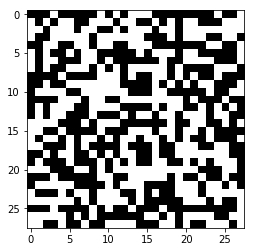

In [0]:
 z = torch.rand(10, 1, 28, 28) #.cuda()
 z[z<.5] = 0
 z[z>=.5] = 1
  
 plt.imshow(z[1].reshape(28,28), cmap = 'gray')

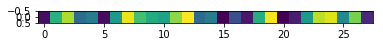

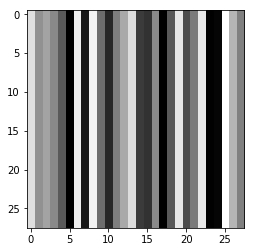

In [0]:
z = torch.rand(10, 1, 28) #.cuda()
# z[z<.5] = 0
# z[z>=.5] = 1
  
plt.imshow(z[1])

zz = torch.stack(28*[z], dim=2)
zz.shape

plt.figure()
plt.imshow(zz[4,0], cmap = 'gray')





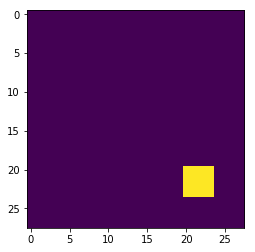

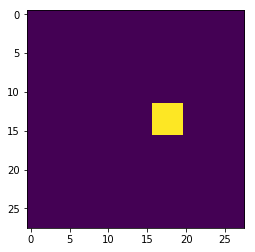

In [0]:
# z = torch.rand(10, 1, 28, 28) #.cuda()
z = np.zeros((10, 1, 7, 7)) #.cuda()
# z[z<.5] = 0
# z[z>=.5] = 1

idx_x = np.random.randint(0,6,(10,))
idx_y = np.random.randint(0,6,(10,))
idx_r = np.random.randint(0,9,(10,))

# idxs = np.radnom.rand()
# idx1 = torch.randint(0,9,(10,2))

# plt.imshow(z[1])

# zz = torch.stack(28*[z], dim=2)
# zz.shape
# z[0,0,idxs[0,0], idxs[0,1]] = 1
# z[:,0,idxs[:0],idxs[:1]] = 1
z[range(10),0,idx_x,idx_y] = 1

z = torch.from_numpy(z)
upsample = nn.Upsample(scale_factor=4, mode='nearest')
z = upsample(z)


plt.figure()
plt.imshow(z[4,0])
# idxs[:,1]
plt.figure()
plt.imshow(z[2,0])


In [0]:
# z.shape
np.random.rand(5,3)

# ar = np.random.rand(2, 3, 5)
# xs = np.array([0, 1, 0, 0, 1])
# ys = np.array([0, 1, 2, 3, 4])
# res = np.random.rand(5,3)
ar[xs, :, ys].shape

(5, 3)

In [0]:
ar[0,...].shape

(3, 5)

In [0]:
# # black and white patterns

# batch_size = 10000
# all_size = 100000


# iters = 10

# stats = dict()
# for i in range(10):
#     stats[i] = 0
    
    
# avgs = torch.zeros(iters, 10, 28*28)

# for kk in range(iters):
#   print(kk)
  
# #   z = torch.rand(all_size, 1, 28, 28)*2 -1 #.cuda()
#   z = torch.rand(all_size, 1, 28, 28) #.cuda()
# #   z[z<.5] = 0
# #   z[z<=.5] = 1
  
#   z.cuda()
#   #plt.imshow(z[1].reshape(28,28))


#   all_preds = []
#   all_confs = []
#   all_idx = torch.ones(all_size, dtype = torch.uint8)
#   for k in range(0,all_size, batch_size):
#       y_pred = model(z[k:k+batch_size].cuda())
#       #y_pred[y_pred < 0]= 0

#       indices = torch.ones(y_pred.size(0), dtype = torch.uint8)
#       indices[torch.mean(y_pred, dim =1)==0] = 0 

#       all_idx[k:k+batch_size] = indices 
#       confs, pred = y_pred[indices==1].data.max(1)
      
#       all_preds.append(pred)
#       all_confs.append(confs)

#   pred = torch.cat(all_preds)
#   confs = torch.cat(all_confs)
  
#   for i in range(10):
#     stats[i] += torch.sum(pred==i)
  

#   tt = confs[:,None].repeat(1,784)
#   uu = z[all_idx].view(-1,28*28)
# #   z = z[all_idx]*confs
#   z = uu* tt.type(torch.FloatTensor)
#   z = z.view(-1,1,28,28)
  
#   for i in range(10):
#       a = torch.mean(z[pred==i] , dim=0) 
#       avgs[kk, i] = a.reshape(28*28)


In [0]:
# with random stripes  --> did not work
# zz = torch.stack(28*[z], dim=2)
# clean one

upsample = nn.Upsample(scale_factor=4, mode='nearest')


batch_size = 10000
all_size = 100000
iters = 10

stats = dict()
for i in range(10):
    stats[i] = 0    
    
avgs = torch.zeros(iters, 10, 28*28)

for kk in range(iters):
  print(kk)
  
#   z = torch.rand(all_size, 1, 28) #.cuda() 
#   z = torch.stack(28*[z], dim=2)   stripes
  z = np.zeros((all_size, 1, 7, 7)) #.cuda()

  idx_x = np.random.randint(0,6,(all_size,))
  idx_y = np.random.randint(0,6,(all_size,))
#   idx_r = np.random.randint(0,all_size-1,(all_size,))

  z[range(all_size),0,idx_x,idx_y] = 1

  z = torch.from_numpy(z)
  z = upsample(z)
  z = z.type(torch.FloatTensor)
  z.cuda()

  all_preds = []
  all_confs = []

  for k in range(0,all_size, batch_size):
      y_pred = model(z[k:k+batch_size].cuda())
      conf, pred = y_pred.data.max(1)
      
      
      all_preds.append(pred)
      all_confs.append(conf)
  
  preds = torch.cat(all_preds)
  confs = torch.cat(all_confs)    
  
#   weighting
  tt = confs[:,None].repeat(1,784)
  uu = z.view(-1,28*28)
  z = uu* tt.type(torch.FloatTensor)
  z = z.view(-1,1,28,28)

  for i in range(10):
    stats[i] += torch.sum(preds==i)
    a = torch.mean(z[preds==i] , dim=0) 
    avgs[kk, i] = a.reshape(28*28)


0
1
2
3
4
5
6
7
8
9


In [0]:
z.shape

torch.Size([100000, 1, 28, 28])

In [0]:
# clean one

batch_size = 10000
all_size = 100000
iters = 100

stats = dict()
for i in range(10):
    stats[i] = 0    
    
avgs = torch.zeros(iters, 10, 28*28)

for kk in range(iters):
  print(kk)
  
  z = torch.rand(all_size, 1, 28, 28) #.cuda()  
  z.cuda()

  all_preds = []
  all_confs = []

  for k in range(0,all_size, batch_size):
      y_pred = model(z[k:k+batch_size].cuda())
      conf, pred = y_pred.data.max(1)
      
      
      all_preds.append(pred)
      all_confs.append(conf)
  
  preds = torch.cat(all_preds)
  confs = torch.cat(all_confs)    
  
#   weighting
  tt = confs[:,None].repeat(1,784)
  uu = z.view(-1,28*28)
  z = uu* tt.type(torch.FloatTensor)
  z = z.view(-1,1,28,28)

  for i in range(10):
    stats[i] += torch.sum(preds==i)
    a = torch.mean(z[preds==i] , dim=0) 
    avgs[kk, i] = a.reshape(28*28)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
{0: tensor(52900, device='cuda:0'), 1: tensor(289, device='cuda:0'), 2: tensor(234775, device='cuda:0'), 3: tensor(36193, device='cuda:0'), 4: tensor(53767, device='cuda:0'), 5: tensor(2846, device='cuda:0'), 6: tensor(24, device='cuda:0'), 7: tensor(1435, device='cuda:0'), 8: tensor(9601045, device='cuda:0'), 9: tensor(1525, device='cuda:0')}


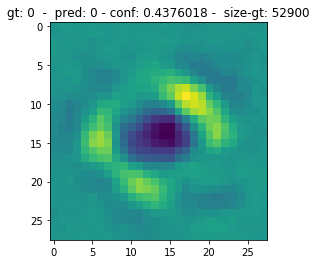

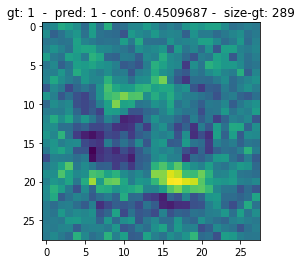

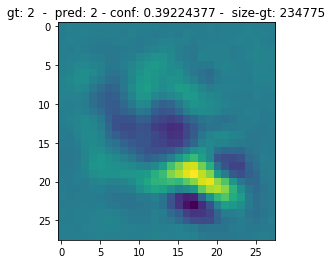

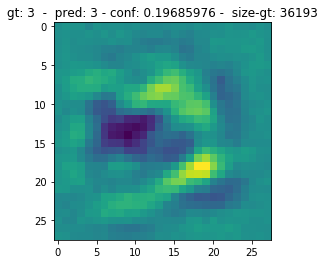

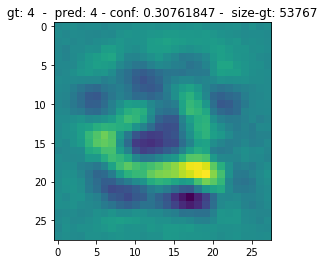

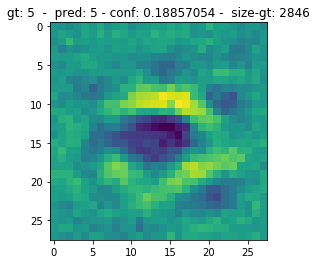

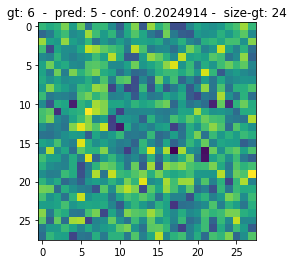

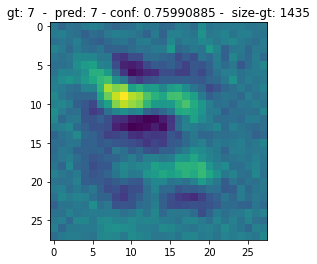

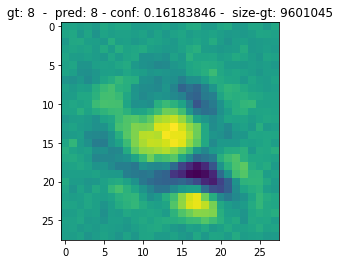

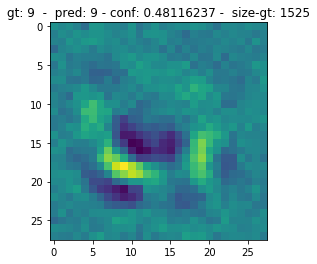

In [0]:
# based on confidence

batch_size = 10000
all_size = 100000
iters = 100

stats = dict()
for i in range(10):
    stats[i] = 0    
    
avgs = torch.zeros(iters, 10, 28*28)

for kk in range(iters):
  print(kk)
  
  z = torch.rand(all_size, 1, 28, 28) #.cuda()  
  z.cuda()

  all_preds = []
  all_confs = []
  all_idx = torch.ones(all_size, dtype = torch.uint8)

  for k in range(0,all_size, batch_size):
      y_pred = model(z[k:k+batch_size].cuda())
      
      # erasing the low confident ones!
      y_pred[y_pred <= 0.3]= 0
      indices = torch.ones(y_pred.size(0), dtype = torch.uint8)
      indices[torch.mean(y_pred, dim =1)==0] = 0 
      all_idx[k:k+batch_size] = indices 
      conf, pred = y_pred[indices==1].data.max(1)#[1]

      #if (not torch.isnan(conf).sum()) & (not torch.isnan(pred).sum())  :
      all_preds.append(pred)
      all_confs.append(conf)
  
  all_preds = torch.cat(all_preds)
  all_confs = torch.cat(all_confs)    
  
  # weighting
#   tt = confs[:,None].repeat(1,784)
#   uu = z.view(-1,28*28)
#   z = uu* tt.type(torch.FloatTensor)
#   z = z.view(-1,1,28,28)

# erasing the low confident ones!
  z = z[all_idx]
    
  for i in range(10):
    stats[i] += torch.sum(all_preds==i)
    a = torch.mean(z[all_preds==i] , dim=0) 
#     print(z[preds==i].shape)
    avgs[kk, i] = a.reshape(28*28)

  
  
  
  
  
print(stats)  
  
  
  
# plotting  
save_path = 'drive/My Drive/classification_images/10way-unweighted'
import os

# setting NANs to 0
avgs[avgs != avgs] = 0 

dd = torch.mean(avgs, dim=0)

#dd = dd - grand_mean
for kk in range(10):
  
  fig = plt.figure()
  a = dd[kk]
  a = a.view(-1,28)
  b = model(a[None,None,...].cuda())

  #a = torch.nn.functional.log_softmax(a)# torch.nn.functional.softmax(a)
  conf, c = b.data.max(1) #[1]
  plt.title(f'gt: {str(kk)}  -  pred: {str(c.cpu().data[0].numpy())} - conf: {str(conf.cpu().data[0].numpy())} -  size-gt: {stats[kk]}')  
  plt.imshow(a) #, cmap = 'gray')
  #fig.savefig(os.path.join(save_path, str(kk)+'-.png'))
    
  

tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)


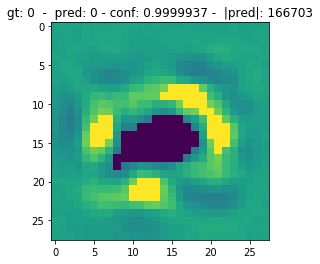

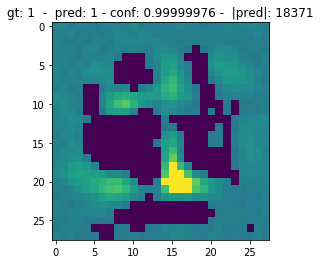

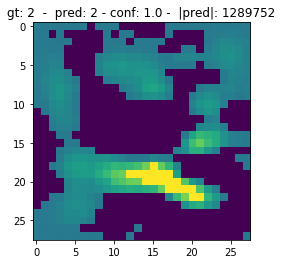

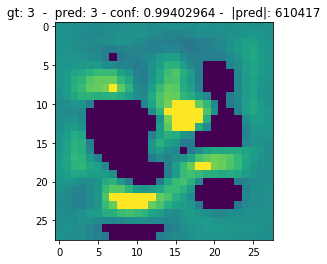

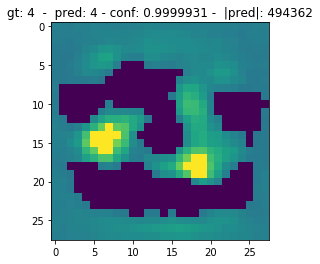

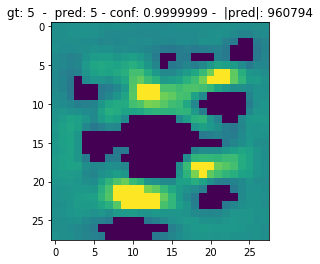

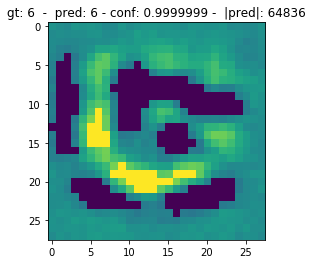

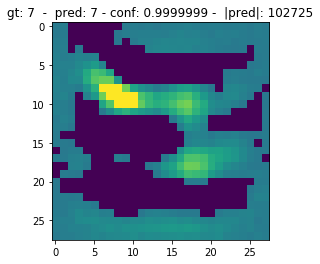

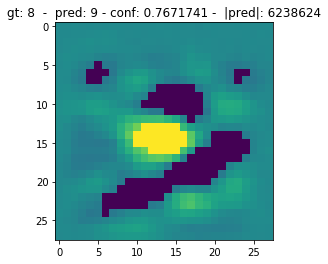

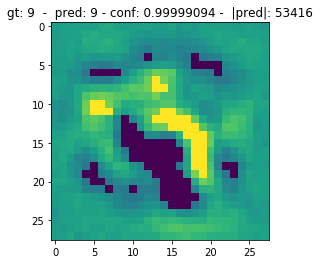

In [0]:
avgs[:,6]
# not torch.isnan(pred).sum()
# stats
# z[preds==1]
(preds==6)
# stats


avgs[:,6].shape




# plotting  
save_path = 'drive/My Drive/classification_images/10way-weighted-2Run'
import os

# setting NANs to 0
avgs[avgs != avgs] = 0 

dd = torch.mean(avgs, dim=0)

#dd = dd - grand_mean
for kk in range(10):
  
  fig = plt.figure()
  a = dd[kk]
  
  a = (a -a.min()) / (a.max() -a.min())
  a = a.view(-1,28)
  
#   a[a<.4] = 0
#   a[a>=.8] = 1
  
  print(a.min(), a.max())
  b = model(a[None,None,...].cuda())

  #a = torch.nn.functional.log_softmax(a)# torch.nn.functional.softmax(a)
  conf, c = b.data.max(1) #[1]
  plt.title(f'gt: {str(kk)}  -  pred: {str(c.cpu().data[0].numpy())} - conf: {str(conf.cpu().data[0].numpy())} -  |pred|: {stats[kk]}')  
  plt.imshow(a) #, cmap = 'gray')
#   fig.savefig(os.path.join(save_path, str(kk)+'-.png'))

In [0]:
# batch_size = 10000
# all_size = 100000

# stats = dict()
# for i in range(10):
#     stats[i] = 0
    
    
# avgs = torch.zeros(100, 10, 28*28)

# for kk in range(100):
#   print(kk)
  
# #   z = torch.rand(all_size, 1, 28, 28)*2 -1 #.cuda()
#   z = torch.rand(all_size, 1, 28, 28) #.cuda()
  
#   z.cuda()
#   #plt.imshow(z[1].reshape(28,28))


#   all_preds = []
#   all_idx = torch.ones(all_size, dtype = torch.uint8)
#   for k in range(0,all_size, batch_size):
#       y_pred = model(z[k:k+batch_size].cuda())
#       #y_pred[y_pred < 0]= 0

#       indices = torch.ones(y_pred.size(0), dtype = torch.uint8)
#       indices[torch.mean(y_pred, dim =1)==0] = 0 

#       all_idx[k:k+batch_size] = indices 
#       pred = y_pred[indices==1].data.max(1)[1]

#       all_preds.append(pred)

#   pred = torch.cat(all_preds)

#   for i in range(10):
#     stats[i] += torch.sum(pred==i)
  
#   z = z[all_idx]
#   for i in range(10):
#       a = torch.mean(z[pred==i] , dim=0) 
#       avgs[kk, i] = a.reshape(28*28)


In [0]:
z = torch.rand(1000000, 784)
grand_mean = torch.mean(z,dim=0)

In [0]:
# torch.nn.functional.softmax(a)
# d = defaultdict()

NameError: ignored

In [0]:
stats

{0: tensor(166703, device='cuda:0'),
 1: tensor(18371, device='cuda:0'),
 2: tensor(1289752, device='cuda:0'),
 3: tensor(610417, device='cuda:0'),
 4: tensor(494362, device='cuda:0'),
 5: tensor(960794, device='cuda:0'),
 6: tensor(64836, device='cuda:0'),
 7: tensor(102725, device='cuda:0'),
 8: tensor(6238624, device='cuda:0'),
 9: tensor(53416, device='cuda:0')}

In [0]:
# grand_mean.shape
import sklearn
from sklearn import metrics
sklearn.metrics.confusion_matrix(pred.cpu().numpy(), evaluate_y.cpu().numpy())


array([[ 11,  16,  12,  18,  17,   3,  10,  12,  17,  11],
       [  3,   3,   3,   3,   3,   0,   2,   0,   2,   2],
       [127, 136, 148, 117, 120, 118, 129, 137, 144, 142],
       [  9,  12,   9,  13,   7,   6,   9,   4,   8,   8],
       [ 33,  24,  31,  27,  28,  37,  26,  37,  29,  37],
       [  3,   7,   3,   4,   3,   2,   3,   2,   3,   5],
       [  3,   0,   1,   1,   0,   0,   0,   2,   1,   0],
       [  3,   2,   3,   3,   5,   1,   2,   3,   4,   2],
       [788, 933, 821, 823, 794, 723, 773, 830, 765, 802],
       [  0,   2,   1,   1,   5,   2,   4,   1,   1,   0]])

In [0]:
b.data.max(1)[1]
b
a.shape
# avgs

torch.Size([1, 28, 28])

In [0]:
for i in range(10):
    print(torch.sum(pred==i))  


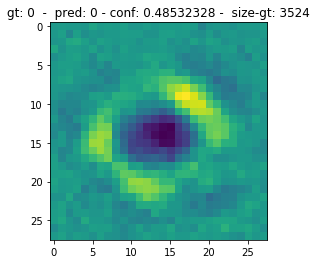

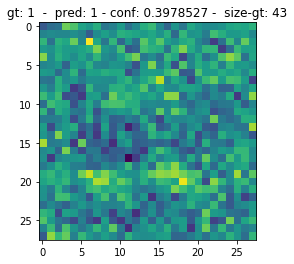

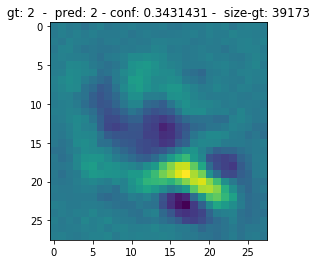

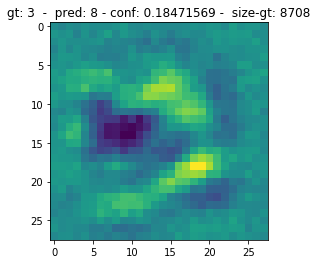

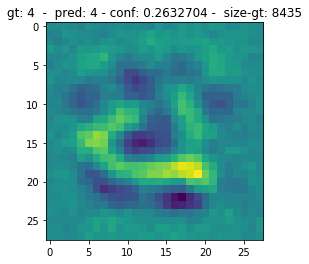

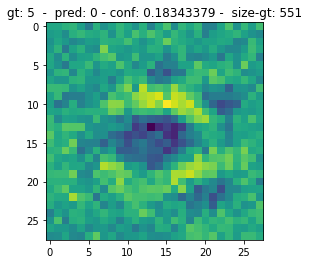

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:918: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/usr/local/lib/python3.6/dist-packages/numpy/ma/core.py:713: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


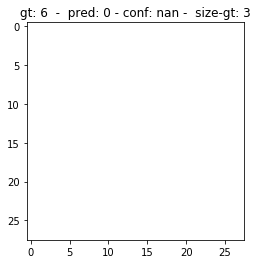

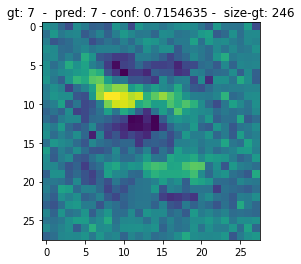

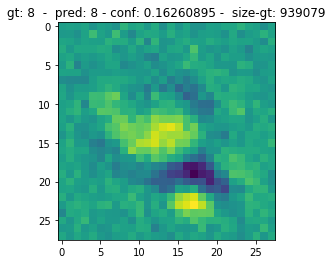

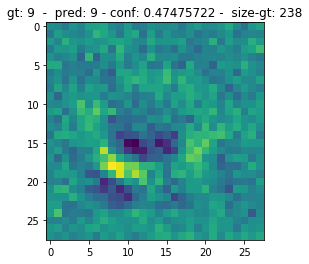

In [0]:
#   
# - load the model
# - modulate the input
# - see how many are classified as the pattern

import os

model = Model()
if cuda:
    model.cuda() # CUDA!
    
model = torch.load(os.path.join(save_path, 'cnn.pth'))



In [0]:
import torch.nn.functional as F
def resize2d(img, size):
    return (F.adaptive_avg_pool2d(Variable(img,volatile=True), size)).data

  
from skimage import io, transform  
import sklearn
from sklearn import metrics


import matplotlib.pyplot as plt
import matplotlib.image as mpimg  # for reading image
import matplotlib.cm as cm


# https://stackoverflow.com/questions/25862026/turn-off-axes-in-subplots/25864515


tensor([8, 8, 2, 8, 6, 4, 5, 8, 8, 8, 8, 8, 5, 5, 8, 8, 2, 8, 3, 2, 8, 8, 8, 8,
        3, 8, 2, 0, 8, 8, 8, 8, 3, 8, 8, 2, 3, 8, 2, 8, 2, 8, 2, 8, 3, 4, 8, 2,
        2, 5, 5, 8, 8, 8, 8, 2, 2, 2, 0, 8, 4, 8, 8, 8, 8, 2, 8, 8, 3, 3, 2, 8,
        8, 8, 8, 4, 8, 8, 8, 2, 8, 2, 8, 8, 8, 8, 8, 5, 4, 8, 8, 8, 8, 2, 8, 8,
        8, 8, 6, 8])


([<matplotlib.axis.XTick at 0x7f90fd192400>,
 <a list of 9 Text xticklabel objects>)

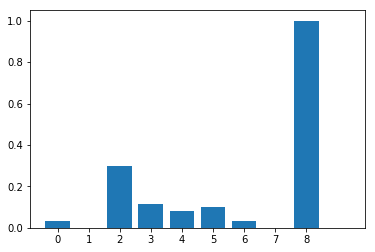

In [0]:
z.max()
plt.figure()
y_pred = model(z.cuda())
preds = y_pred.data.max(1)[1].cpu()
print(preds)
freq = numpy.histogram(preds.numpy(), bins=list(range(11))) 
y_pos = np.arange(len(freq[0]))
plt.bar(y_pos, freq[0]/freq[0].max())
plt.xticks(list(range(9)))

In [0]:
# torch.histc(preds.type(torch.FloatTensor), bins=10)
(preds==8).sum()
# numpy.coun
freq

(array([ 2,  0, 18,  7,  5,  6,  2,  0, 60]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

misclassification rate: 0.0
misclassification rate: 0.00019999999494757503
misclassification rate: 0.0
misclassification rate: 0.0
misclassification rate: 0.0
misclassification rate: 0.0
misclassification rate: 0.0
misclassification rate: 0.0
misclassification rate: 0.00019999999494757503
misclassification rate: 0.0
4e-05


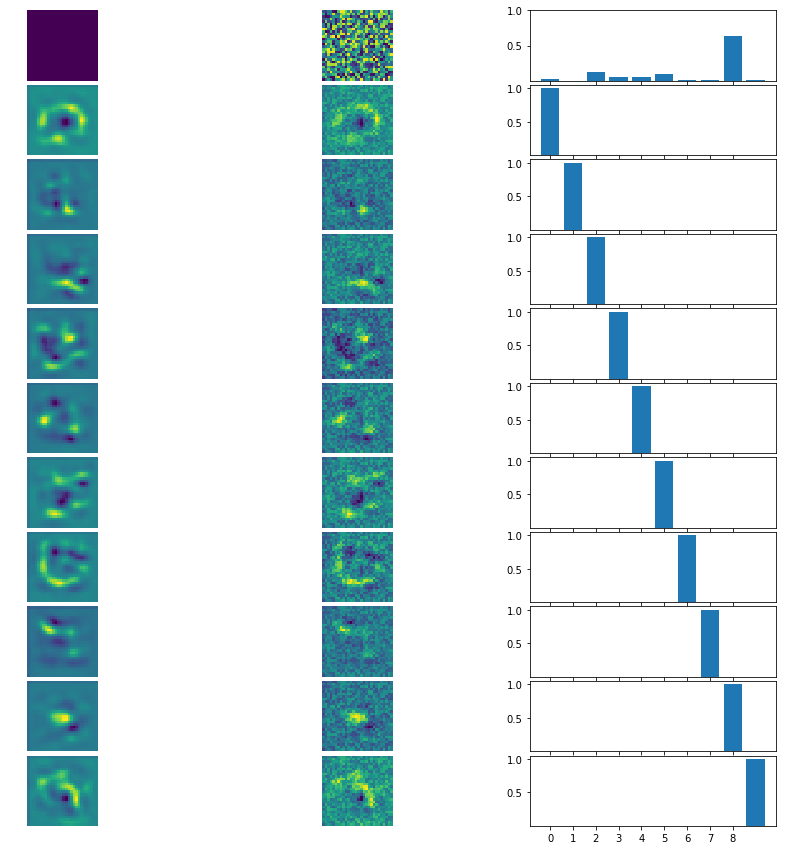

In [0]:
# load the zero image
# objects = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# save_path = 'drive/My Drive/classification_images/10way-weighted'


z = torch.rand(10000, 1, 28, 28) #.cuda()
weight = .9


# frequency of noise predictions
f, axarr = plt.subplots(11, 3)
# f.set_figheight(1.4)
# f.set_figwidth(15)
f.set_figheight(15)
f.set_figwidth(15)




# fixed noise 
axarr[0,0].imshow(torch.torch.ones_like(torch.squeeze(z[0,...],0)))
axarr[0,0].axis('off')


# fixed noise 
axarr[0,1].imshow(torch.squeeze(z[0,...],0))
axarr[0,1].axis('off')



y_pred = model(z.cuda())
preds = y_pred.data.max(1)[1].cpu()
# print(preds)
freq = numpy.histogram(preds.numpy(), bins=list(range(11))) 
y_pos = np.arange(len(freq[0]))
axarr[0,2].bar(y_pos, freq[0]/freq[0].sum())
axarr[0,2].set_yticks([0.5,1]) 
# axarr[0,2].set_xticks(list(range(9))) 
# axarr[0,2].set_ylim([0,1])
# axarr[0,2].axis('on')



# plt.subplots_adjust(hspace=0.01, wspace=0.01)
# plt.show()




# f, axarr = plt.subplots(10, 3, )
# f.set_figheight(15)
# f.set_figwidth(15)

mis_class = []

for i in range(1,11):
  # pattern
  pattern =  io.imread(os.path.join(save_path, str(i-1) + '-.png'))
  pattern = pattern[35:35+217,113:330,:]
  pattern = transform.resize(pattern, (28, 28))
  pattern = torch.from_numpy(pattern)
  pattern = pattern.type(torch.FloatTensor)
  pattern = torch.mean(pattern, dim=2)

  axarr[i,0].imshow(pattern)
  axarr[i,0].axis('off')
  
  

  
  # pattern + noise
  z_new = (1-weight)*z + weight*pattern #/ (weight+1)  # noise + stim
#   z_new = (z_new - z_new.min()) / (z_new.min() - z_new.min())
#   print(z_new.min(),z_new.max())
  axarr[i,1].imshow(torch.squeeze(z_new[0,...],0))
  axarr[i,1].axis('off')

  
  
  
  # frequency of pattern + noise predictions  
  y_pred = model(z_new.cuda())
  preds = y_pred.data.max(1)[1].cpu()
#   print(preds)  
  freq = numpy.histogram(preds.numpy(), bins=list(range(11))) 
  y_pos = np.arange(len(freq[0]))
  axarr[i,2].bar(y_pos, freq[0]/freq[0].sum())
  axarr[i,2].set_xticks(list(range(9))) 
  axarr[i,2].set_yticks([0.5,1]) 

  
  f.subplots_adjust(hspace=0.06) #, wspace=0.0, right = 0.8)
  f.show()
  
#   axarr[i,2].axis('off')

  error = (preds != i-1).sum().type(torch.FloatTensor)/preds.size(0)
  print(f'misclassification rate: {error}')
  mis_class.append(error)
  
print(mean(mis_class))

torch.Size([96, 1, 28, 28])

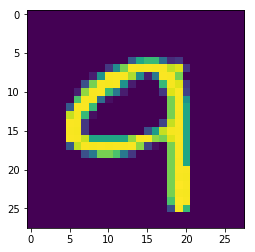

In [0]:
data = data.cpu()
plt.imshow(data[5,0])
data.shape

In [0]:
z.shape
# z.min().shape
# z

torch.Size([10000, 1, 28, 28])

misclassification rate: 0.010200000368058681
misclassification rate: 0.010300000198185444
misclassification rate: 0.010300000198185444
misclassification rate: 0.00989999994635582
misclassification rate: 0.009999999776482582
misclassification rate: 0.010300000198185444
misclassification rate: 0.010300000198185444
misclassification rate: 0.009999999776482582
misclassification rate: 0.009999999776482582
misclassification rate: 0.010099999606609344
0.01014


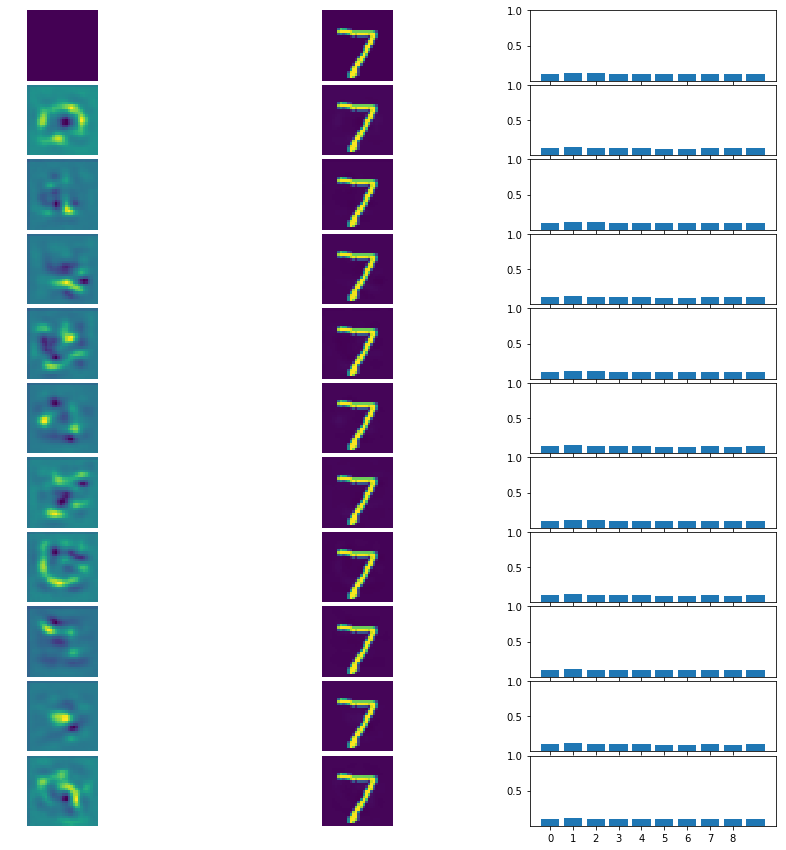

In [0]:
# load the zero image


# Load data
# data = mnist_data()

# tt = data.targets[data.targets==9]
# dd = data.data[data.targets==9] 
# data.targets = tt
# data.data = dd
# data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True, drop_last =True)
# # Num batches

# z = next(iter(test_loader)) 
z = test.data # 10K test images
z = z[:,None,...]
z = z.type(torch.FloatTensor)
z = (z - z.min())/(z.max() - z.min())



# noise = torch.rand(1, 1, 28, 28) #.cuda()
weight = .1


# frequency of noise predictions
f, axarr = plt.subplots(11, 3)
# f.set_figheight(1.4)
# f.set_figwidth(15)
f.set_figheight(15)
f.set_figwidth(15)




# fixed noise 
axarr[0,0].imshow(torch.torch.ones_like(torch.squeeze(z[0,...],0)))
axarr[0,0].axis('off')


# fixed noise 
axarr[0,1].imshow(torch.squeeze(z[0,...],0))
axarr[0,1].axis('off')



y_pred = model(z.cuda())
preds = y_pred.data.max(1)[1].cpu()
# print(preds)
freq = numpy.histogram(preds.numpy(), bins=list(range(11))) 
y_pos = np.arange(len(freq[0]))
axarr[0,2].bar(y_pos, freq[0]/freq[0].sum())
axarr[0,2].set_yticks([0.5,1]) 


mis_class = []


for i in range(1,11):
  # pattern
  pattern =  io.imread(os.path.join(save_path, str(i-1) + '-.png'))
  pattern = pattern[35:35+217,113:330,:]
  pattern = transform.resize(pattern, (28, 28))
  pattern = torch.from_numpy(pattern)
  pattern = pattern.type(torch.FloatTensor)
  pattern = torch.mean(pattern, dim=2)

  axarr[i,0].imshow(pattern)
  axarr[i,0].axis('off')
  
  
  # pattern + noise
  z_new = (1-weight)*z + weight*pattern #/ (weight+1)  # noise + stim
#   z_new = (z_new - z_new.min()) / (z_new.min() - z_new.min())
#   print(z_new.min(),z_new.max())
  axarr[i,1].imshow(torch.squeeze(z_new[0,...],0))
  axarr[i,1].axis('off')
  
  
  # frequency of pattern + noise predictions  
  y_pred = model(z_new.cuda())
  preds = y_pred.data.max(1)[1].cpu()
#   print(preds)  
  freq = numpy.histogram(preds.numpy(), bins=list(range(11))) 
  y_pos = np.arange(len(freq[0]))
  axarr[i,2].bar(y_pos, freq[0]/freq[0].sum())
  axarr[i,2].set_xticks(list(range(9))) 
  axarr[i,2].set_yticks([0.5,1]) 
  preds 
  
  f.subplots_adjust(hspace=0.06) #, wspace=0.0, right = 0.8)
  f.show()
  
  
  error = (preds != test.targets).sum().type(torch.FloatTensor)/preds.size(0)
  print(f'misclassification rate: {error}')
  mis_class.append(error)
  
print(mean(mis_class))

In [0]:
mean(mis_class)

0.11918

In [0]:
pattern =  io.imread(os.path.join(save_path, str(i) + '-.png'))
pattern = transform.resize(pattern, (28, 28))
pattern.shape
pattern = torch.mean(pattern, dim=2)


https://stackoverflow.com/questions/19626530/python-xticks-in-subplots

TypeError: ignored

In [0]:
# digits = next(iter(train_loader))

# 1326/2000

tensor(0.1326)

In [0]:
from torchvision import transforms, datasets
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5), (.5))         
#          transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    transform = transforms.Compose([
        transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])    
    
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=transform, download=True)




In [0]:
train_loader

AttributeError: ignored

tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 7, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')
tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 

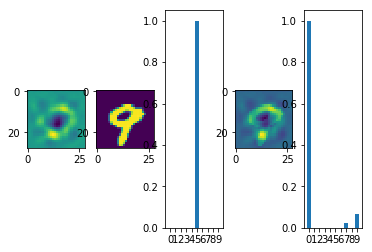

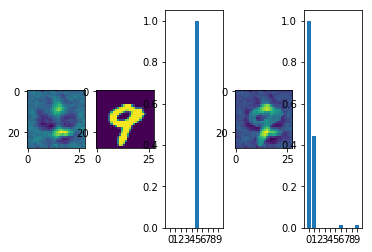

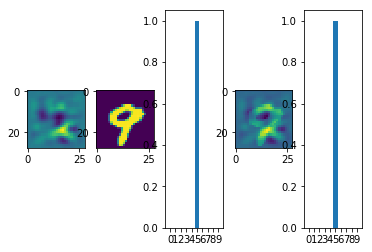

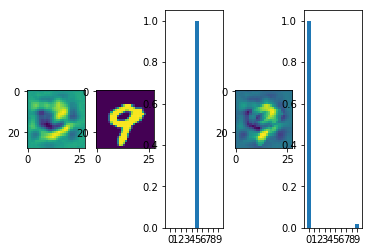

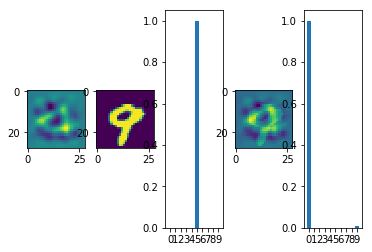

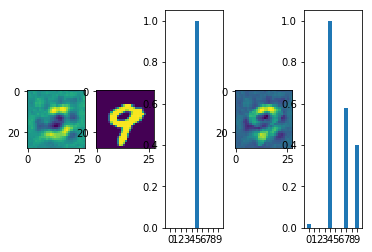

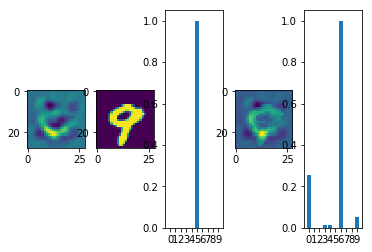

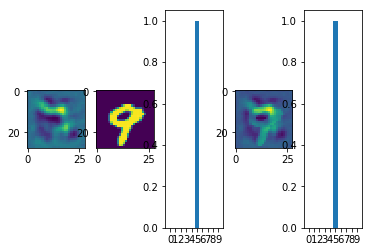

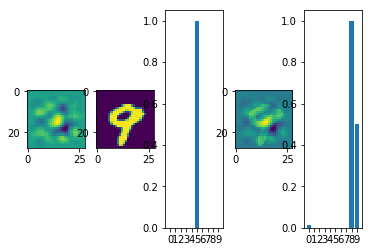

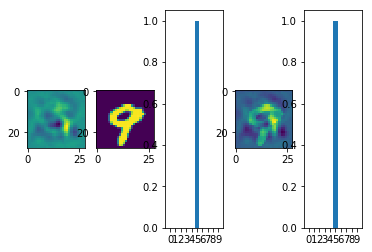

In [0]:
# ls 'drive/My Drive/classification_images'
# torch.squeeze(z[0,...],0).shape
# plt.hist(y_pred.data.max(1)[1].cpu())

objects = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
# evaluate_y = Variable(test_loader.dataset.test_labels)
# if cuda:
#     evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()


#digits = next(iter(train_loader))



# Load data
data = mnist_data()

tt = data.targets[data.targets==9]
dd = data.data[data.targets==9] 
data.targets = tt
data.data = dd
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True, drop_last =True)
# Num batches

z = next(iter(data_loader)) 


for i in range(10):

  pattern =  io.imread(os.path.join(save_path, str(i) + '-.png'))
  pattern = pattern[35:35+217,113:330,0]
  pattern = transform.resize(pattern, (28, 28))
  # pattern = torch.from_numpy(pattern)

  pattern = torch.from_numpy(pattern)
  pattern = pattern.type(torch.FloatTensor)

  plt.figure()
  plt.subplot(151)
  plt.imshow(pattern)

  z_old = (z[0] + 1)/2
  
  plt.subplot(152)
  plt.imshow(torch.squeeze(z_old[0,...],0))

  y_pred = model(z_old.cuda())
  print(y_pred.data.max(1)[1])
  
  
  plt.subplot(153)
  freq = y_pred.data.max(1)[1].cpu()
  aa = numpy.histogram(freq.numpy()) 
  y_pos = np.arange(len(aa[0]))
  plt.bar(y_pos, aa[0]/aa[0].max())
  plt.xticks(y_pos, objects)

  
  z_new = .3*z_old + pattern

  plt.subplot(154)
  plt.imshow(torch.squeeze(z_new[0,...],0))

  y_pred = model(z_new.cuda())
#   print(y_pred.data.max(1)[1])
  
  plt.subplot(155)
  freq = y_pred.data.max(1)[1].cpu()
  aa = numpy.histogram(freq.numpy()) 
  y_pos = np.arange(len(aa[0]))
  plt.bar(y_pos, aa[0]/aa[0].max())
  plt.xticks(y_pos, objects)
  print(y_pred.data.max(1)[1])
#   plt.bar()
#   plt.hist(y_pred.data.max(1)[1].cpu())

In [0]:
  z.min()

tensor(0.)

In [0]:
for i in range(10):
    print(torch.sum(pred==i))

tensor(236, device='cuda:0')
tensor(3, device='cuda:0')
tensor(1874, device='cuda:0')
tensor(160, device='cuda:0')
tensor(2689, device='cuda:0')
tensor(22, device='cuda:0')
tensor(44, device='cuda:0')
tensor(81, device='cuda:0')
tensor(93796, device='cuda:0')
tensor(98, device='cuda:0')


In [0]:
# ls
from google.colab import files
files.download('./*.png')


FileNotFoundError: ignored

In [0]:
ls drive/My\ Drive/classification_images


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


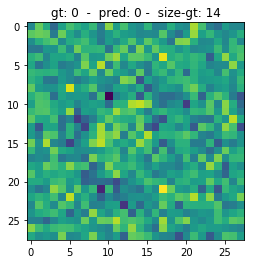

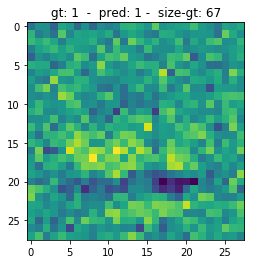

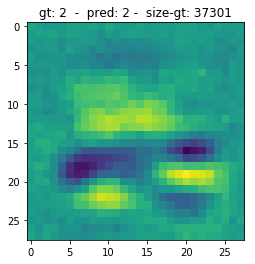

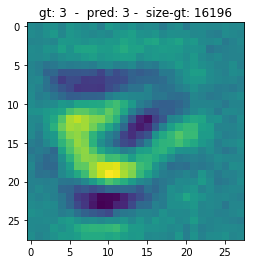

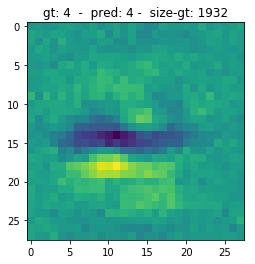

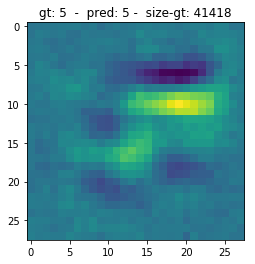

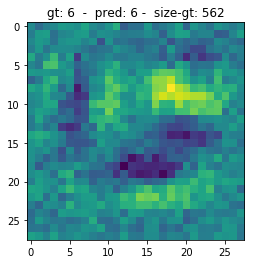

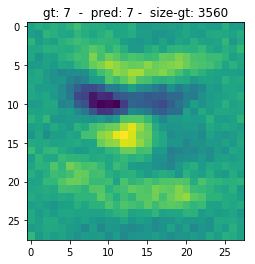

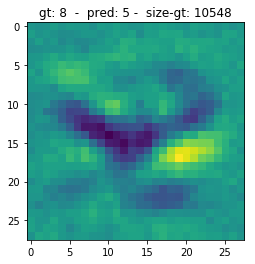

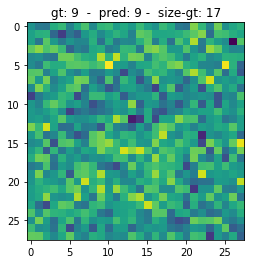

In [0]:
# z = z[all_idx]
pred = torch.cat(all_preds)
for i in range(10):
    plt.figure()
    a = torch.mean(z[pred==i] , dim=0) 
    a = a.view(-1,28)
    b = model(a[None,None,...].cuda())
    c = b.data.max(1)[1]
    plt.title(f'gt: {str(i)}  -  pred: {str(c.cpu().data[0].numpy())} -  size-gt: {z[pred==i].size(0)}')
    plt.imshow(1-a)

In [0]:
# for i in range(z.size(0)):
#   print(torch.max(data[1,0]))

In [0]:
# Repeating the above experiment with VGG and ResNet 
# VGG16

# https://towardsdatascience.com/model-summary-in-pytorch-b5a1e4b64d25


import torch
from torchvision import models
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg = models.vgg16().to(device)
summary(vgg, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [0]:
# ResNet

# https://zablo.net/blog/post/using-resnet-for-mnist-in-pytorch-tutorial/


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model
  
  

def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    ## ... skipped a few lines ...
    return x
  
self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)



class MnistResNet(ResNet):
    def __init__(self):
        super(MnistResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=10)
        self.conv1 = torch.nn.Conv2d(1, 64, 
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3), bias=False)
        
    def forward(self, x):
        return torch.softmax(
            super(MnistResNet, self).forward(x), dim=-1)

      
      
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.datasets import MNIST
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import time
from torch import nn, optim
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader





NameError: ignored

In [0]:
# model:
model = YourModelHere()

# params you need to specify:
epochs = 5
train_loader, val_loader = # put your data loader here
loss_function = nn.CrossEntropyLoss() # your loss function, cross entropy works well for multi-class problems

# optimizer, I've used Adadelta, as it wokrs well without any magic numbers
optimizer = optim.Adadelta(model.parameters())

start_ts = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

losses = []
batches = len(train_loader)
val_batches = len(val_loader)

# loop for every epoch (training + evaluation)
for epoch in range(epochs):
    total_loss = 0

    # progress bar (works in Jupyter notebook too!)
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

    # ----------------- TRAINING  -------------------- 
    # set model to training
    model.train()
    
    for i, data in progress:
        X, y = data[0].to(device), data[1].to(device)
        
        # training step for single batch
        model.zero_grad()
        outputs = model(X)
        loss = loss_function(outputs, y)
        loss.backward()
        optimizer.step()

        # getting training quality data
        current_loss = loss.item()
        total_loss += current_loss

        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))
        
    # releasing unceseccary memory in GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # ----------------- VALIDATION  ----------------- 
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []
    
    # set model to evaluating (testing)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, y = data[0].to(device), data[1].to(device)

            outputs = model(X) # this get's the prediction from the network

            val_losses += loss_function(outputs, y)

            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
            
            # calculate P/R/F1/A metrics for batch
            for acc, metric in zip((precision, recall, f1, accuracy), 
                                   (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(
                    calculate_metric(metric, y.cpu(), predicted_classes.cpu())
                )
          
    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    print_scores(precision, recall, f1, accuracy, val_batches)
    losses.append(total_loss/batches) # for plotting learning curve
print(f"Training time: {time.time()-start_ts}s")

SyntaxError: ignored

In [0]:
def calculate_metric(metric_fn, true_y, pred_y):
    # multi class problems need to have averaging method
    if "average" in inspect.getfullargspec(metric_fn).args:
        return metric_fn(true_y, pred_y, average="macro")
    else:
        return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
    # just an utility printing function
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
        print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

In [0]:
def get_data_loaders(train_batch_size, val_batch_size):
    mnist = MNIST(download=False, train=True, root=".").train_data.float()
    
    data_transform = Compose([ Resize((224, 224)),ToTensor(), Normalize((mnist.mean()/255,), (mnist.std()/255,))])

    train_loader = DataLoader(MNIST(download=True, root=".", transform=data_transform, train=True),
                              batch_size=train_batch_size, shuffle=True)

    val_loader = DataLoader(MNIST(download=False, root=".", transform=data_transform, train=False),
                            batch_size=val_batch_size, shuffle=False)
    return train_loader, val_loader